

```
# This is formatted as code
```

**Quora duplicates detection**

`Deadline: 23.03.2022 23:59 msk`

In this homework you will learn how to build an LSTM-based siamese homework and search for the duplicates in quora question pairs dataset.

The homework is based on DeepLearning.AI materials.

# [3 points] **Part 1: Loading the dataset & Looking at it**

For this task a well-known quora duplicate detection dataset will be used. We put the data to the "sample_data" folder in the current runtime (not the best option) but you are free to mount a google drive.

In [146]:
import os
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from collections import defaultdict
import random
from math import ceil
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#Jupyter
data = pd.read_csv('train.csv')

In [2]:
# Colab
!gdown --id 1vnT7-aBLaf_HklF-bQWQRRAWWoNEk5ol
data = pd.read_csv('/content/train.csv')

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1vnT7-aBLaf_HklF-bQWQRRAWWoNEk5ol
To: /content/train.csv
100% 63.4M/63.4M [00:02<00:00, 22.5MB/s]


As you can see the data consists of questions, and the indicator whether they are duplicate (1) or not (0). 

In [3]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
data = data[~data['question1'].isna()]
data = data[~data['question2'].isna()]

In [5]:
# non-duplicate example
questions = data[data['is_duplicate'] == 0].loc[0]
print(f'Q1: {questions.question1}\nQ2: {questions.question2}')

Q1: What is the step by step guide to invest in share market in india?
Q2: What is the step by step guide to invest in share market?


In [6]:
# duplicate example
questions = data[data['is_duplicate'] == 1].loc[7]
print(f'Q1: {questions.question1}\nQ2: {questions.question2}')

Q1: How can I be a good geologist?
Q2: What should I do to be a great geologist?


Now the dataset is going to be divided into train and test parts for our analysis.

In [7]:
train, test = train_test_split(data, stratify=data['is_duplicate'], random_state=42)

**Task:** Do a little exploratory analysis. Find how many duplicates and non-duplicates are there in the train part and any other actions of your interest to better understand the data.

In [8]:
# your code here
train_duplicates_count = train['is_duplicate'].sum()
train_nonduplicates_count = train.shape[0] - train_duplicates_count
test_duplicates_count = test['is_duplicate'].sum()
test_nonduplicates_count = test.shape[0] - test_duplicates_count

print(f'Train part. Number of duplicates: {train_duplicates_count}')
print(f'Number of non-duplicates: {train_nonduplicates_count}')
print(f'Test part. Number of duplicates: {test_duplicates_count}')
print(f'Number of non-duplicates: {test_nonduplicates_count}')

Train part. Number of duplicates: 111947
Number of non-duplicates: 191268
Test part. Number of duplicates: 37316
Number of non-duplicates: 63756


Now let's leave only positive examples to train the network. As we remember the negative examples for each of the anchors are taken from the same batch.

In [9]:
train_idx = train[train['is_duplicate'] == 1].id.tolist()
print(f'Number of training examples: {len(train_idx)}')

Number of training examples: 111947


In [10]:
q1_train_data = np.array(train.loc[train_idx, 'question1'])
q2_train_data = np.array(train.loc[train_idx, 'question2'])
q1_test_data = np.array(test['question1'])
q2_test_data = np.array(test['question2'])

q1_train = np.empty_like(q1_train_data)
q2_train = np.empty_like(q2_train_data)
q1_test = np.empty_like(q1_test_data)
q2_test = np.empty_like(q2_test_data)

y_test  = np.array(test['is_duplicate'])

In [11]:
q1_train_data[:5]

array(['Can a Gemini man and a Gemini woman have a successful relationship? Or are they incompatible?',
       'How can I delete my own question from Quora?',
       'Why are there still people who think that the Earth is flat?',
       'What should I do to concentrate more on my studies?',
       'How can one stop caring too much?'], dtype=object)

In [12]:
nltk.download('punkt')

vocab = defaultdict(lambda: 0)
vocab['<PAD>'] = 1

for idx in range(len(q1_train_data)):
    q1_train[idx] = nltk.word_tokenize(q1_train_data[idx])
    q2_train[idx] = nltk.word_tokenize(q2_train_data[idx])
    q = q1_train[idx] + q2_train[idx]
    for word in q:
        if word not in vocab:
            vocab[word] = len(vocab) + 1
print('Vocabulary size is: ', len(vocab))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Vocabulary size is:  36378


In [13]:
# processing test

for idx in range(len(q1_test_data)): 
    q1_test[idx] = nltk.word_tokenize(q1_test_data[idx])
    q2_test[idx] = nltk.word_tokenize(q2_test_data[idx])

Converting the examples to tensors.

In [14]:
for i in range(len(q1_train)):
    q1_train[i] = [vocab[word] for word in q1_train[i]]
    q2_train[i] = [vocab[word] for word in q2_train[i]]

        
for i in range(len(q1_test)):
    q1_test[i] = [vocab[word] for word in q1_test[i]]
    q2_test[i] = [vocab[word] for word in q2_test[i]]

To check the model quality we are going to divide the train part into train and validation. 

In [15]:
q1_train, q1_val, q2_train, q2_val = train_test_split(q1_train, q2_train)

In [45]:
class PairsDataset(torch.utils.data.Dataset):
    def __init__(self, q1, q2):
        self.q1 = q1
        self.q2 = q2

    def __getitem__(self, idx):
        item = (self.q1[idx], self.q2[idx])
        return item

    def __len__(self):
        return len(self.q1)

def iterator(q1, q2, batch_size=128, shuffle=False):
    # padding the sequences to the maximum length amongst the samples in batches
    q1, q2 = data_generator(q1, q2, batch_size, shuffle=shuffle) 
    dataset = PairsDataset(q1, q2)
    return dataset

def data_generator(q1, q2, batch_size, pad=1, shuffle=True):
    """Generator function that yields batches of data

    Args:
        q1 (list): List of transformed (to tensor) questions.
        q2 (list): List of transformed (to tensor) questions.
        batch_size (int): Number of elements per batch.
        pad (int, optional): Pad character defaults to 1.
        shuffle (bool, optional): If the batches should be randomnized or not. Defaults to True.
    Returns:
        tuple: Of the form (input1, input2) with types (numpy.ndarray, numpy.ndarray)
        NOTE: input1: inputs to your model [q1a, q2a, q3a, ...] i.e. (q1a,q1b) are duplicates
              input2: targets to your model [q1b, q2b,q3b, ...] i.e. (q1a,q2i) i!=a are not duplicates
    """
    q1_batch_all = []
    q2_batch_all = []
    idx = 0
    len_q = len(q1)
    question_indexes = [*range(len_q)]
    if shuffle:
        random.shuffle(question_indexes)
    ### START CODE HERE (Replace instances of 'None' with your code) ###  
      # get questions at the `question_indexes` position in q1 and q2
    q1 = [q1[i] for i in question_indexes] #
    q2 = [q2[i] for i in question_indexes] #
    batches_num = ceil(len_q / batch_size)
    q1_batch_all = [[q1[(i*batch_size):((i+1)*batch_size)]] for i in range(batches_num)]
    q2_batch_all = [[q2[(i*batch_size):((i+1)*batch_size)]] for i in range(batches_num)]
    for i in range(batches_num):
        q1_max_len = max(list([len(x) for x in q1_batch_all[i][0]]))
        q2_max_len = max(list([len(x) for x in q2_batch_all[i][0]]))
        max_len = max(q1_max_len, q2_max_len) # extracting the maximum length of the seguences
        max_len = 2**int(np.ceil(np.log2(max_len)))
        q1_batch_all[i] = [np.pad(q, (0, max_len-len(q)), constant_values=pad) for q in q1_batch_all[i][0]] # padding the sequences to max_len with pad symbols
        q2_batch_all[i] = [np.pad(q, (0, max_len-len(q)), constant_values=pad) for q in q2_batch_all[i][0]] # padding the sequences to max_len with pad symbols
        q1_batch_all[i] = np.array(q1_batch_all[i])
        q2_batch_all[i] = np.array(q2_batch_all[i])
    return (q1_batch_all, q2_batch_all)

# [7 points] **Part 2: Buiding the siamese network**

In overall siamese network consists of two identical subnetworks with shared weights.

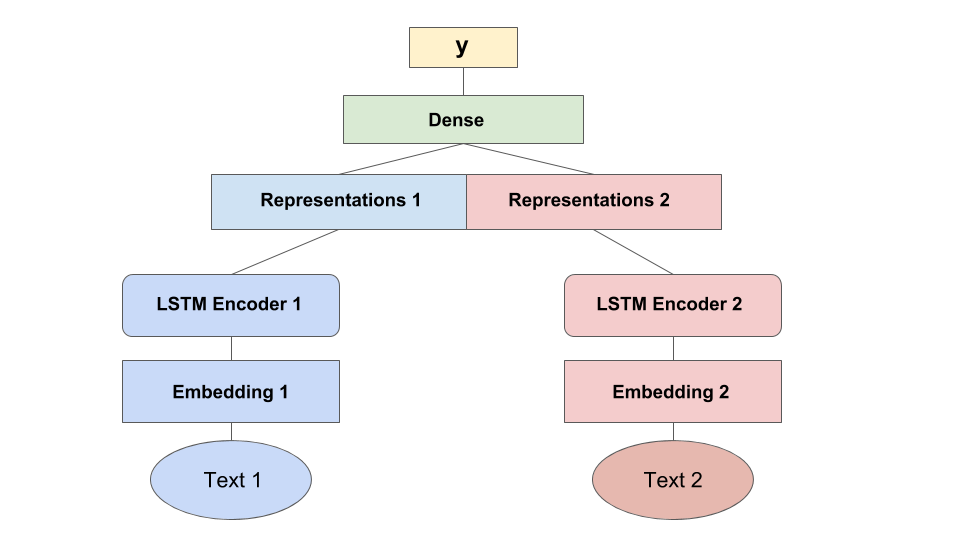

In [177]:
class SiameseModel(nn.Module):
    """ Siamese model.

    Args:
        vocab_size (int, optional): Length of the vocabulary. Defaults to len(vocab).
        d_model (int, optional): Depth of the model. Defaults to 128.
        mode (str, optional): 'train', 'eval' or 'predict', predict mode is for fast inference. Defaults to 'train'.

    Returns:
        A PyTorch Siamese model. 
    """
    def __init__(self, vocab_size=len(vocab), d_model=128, hid_size=256, num_layers=2):
        super(SiameseModel, self).__init__()
        # you are free to modify the network and add additional elements
        self.emb =  nn.Embedding(vocab_size, d_model, device='cuda:0') # defining the embeddings of vocab and d_model size
        self.lstm = nn.LSTM(d_model, hid_size, num_layers=num_layers, batch_first=True, device='cuda:0') # Defining an LSTM layer
        self.ll = nn.Linear(hid_size, hid_size, device='cuda:0') # Using dense layer 

    def forward_once(self, q):
        x = self.emb(q) # make all the transformations with input 
        x, _ = self.lstm(x)
        x = self.ll(x)
        x_mean = x.mean(axis=1) # get the mean accros 1 axis
        out = torch.nn.functional.normalize(x_mean) # normalize the output
        return out

    def forward(self, q1, q2):
        o1 = self.forward_once(q1)
        o2 = self.forward_once(q2)
        return (o1, o2)


# [8 points] **Part 3: Measuring the quality**

To calculate loss we will use `Triplet Loss`. 



As we've taken only the pairs of duplicates to our etraining dataset, because all the other embeddings in butch can be considered negative examples. Thus, after calculating the cosine similarity between embeddings we get matrix where diagonal elements correspond to duplicate examples and all non-diagonal - to negative examples. Mining hard-negatives is quite simple in this case - taking the highest value in a row, without the diagonal element. The final loss uses information on mean negative and hard negative scres.

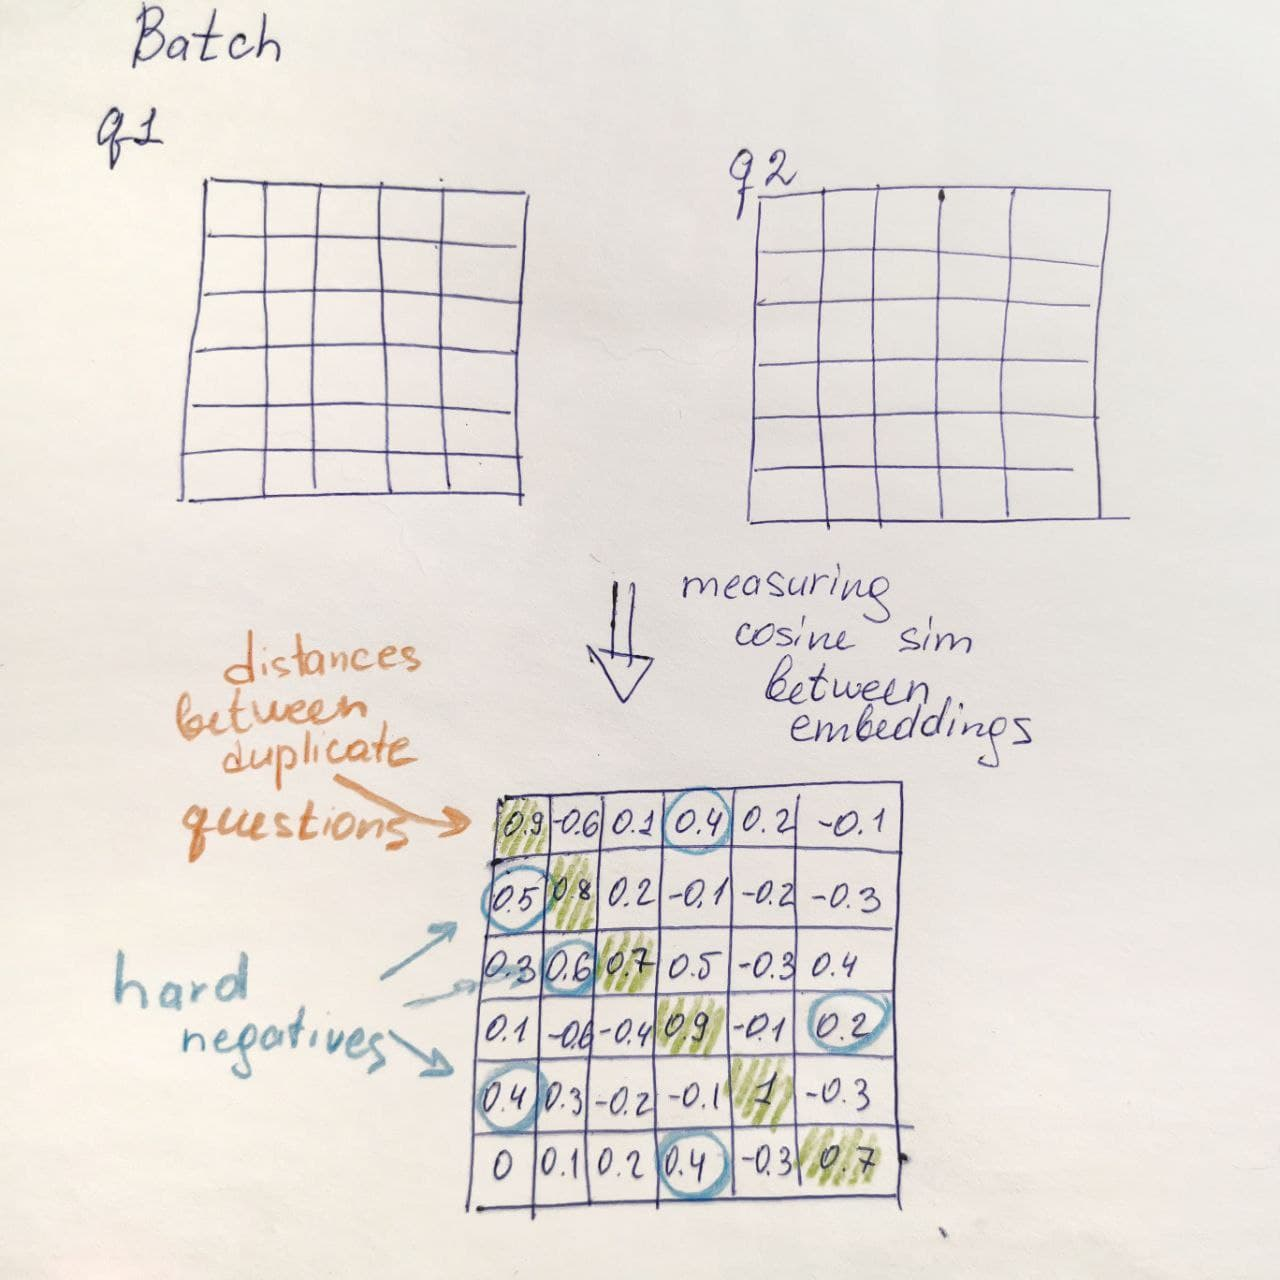

In [180]:
class TripletLoss(torch.nn.Module):
    """Custom Loss function.

    Args:
        v1 (torch.tensor): Array with dimension (batch_size, model_dimension) associated to Q1.
        v2 (torch.tensor): Array with dimension (batch_size, model_dimension) associated to Q2.
        margin (torch.tensor, optional): Desired margin. Defaults to 0.25.

    """

    # use torch functions to autograd the barward step
    def forward(self, v1, v2, margin=torch.tensor([0.25], device='cuda:0')):
        scores = torch.mm(v1, v2.T)
        batch_size = len(scores) # calculate new batch size
        # the positive `diagonal` entries in `scores` (duplicates)
        positive = torch.diagonal(scores, 0).to('cuda:0')
        negative_without_positive = torch.sub(scores, torch.mul(torch.eye(batch_size, device='cuda:0'), 2.0)) # multiply `torch.eye(batch_size)` with 2.0 and subtract it out of `scores`
        # take the row by row `max` of `negative_without_positive`
        closest_negative = torch.max(negative_without_positive, 1).values
        negative_zero_on_duplicate = (1.0 - torch.eye(batch_size, device='cuda:0'))*scores # subtract `torch.eye(batch_size)` out of 1.0 and do element-wise multiplication with `scores`
        
        mean_negative = torch.div(torch.sum(negative_zero_on_duplicate, axis=1), (batch_size - 1)) # use `torch.sum` on `negative_zero_on_duplicate` for `axis=1` and normalize on batch_size - 1
        # subtract `positive` from `margin` and add `closest_negative` and get maximum from this value and 0
        loss1 = torch.max(torch.column_stack((torch.add(torch.sub(margin, positive), closest_negative), torch.zeros(batch_size, device='cuda:0'))), 1).values
        # subtract `positive` from `margin` and add `mean_negative` and get maximum from this value and 0
        loss2 = torch.max(torch.column_stack((torch.add(torch.sub(margin, positive), mean_negative), torch.zeros(batch_size, device='cuda:0'))), 1).values
        
        triplet_loss = torch.mean(torch.add(loss1, loss2))
        return triplet_loss

In [156]:
v1 = torch.tensor(np.array([[ 0.26726124,  0.53452248,  0.80178373],[-0.5178918 , -0.57543534, -0.63297887]]), requires_grad=True, device='cuda:0')
v2 = torch.tensor(np.array([[0.26726124, 0.53452248, 0.80178373],[0.5178918 , 0.57543534, 0.63297887]]), requires_grad=True, device='cuda:0')
loss = TripletLoss()
res = loss(v1, v2)
print("Triplet Loss:", res) # expecting 0.5
res.backward()

Triplet Loss: tensor(0.5000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


# [7 points] **Part 4: Training the model**

To train the model we should define cost function and optimizer and the model input.

In [121]:
# you can vary the hyperparams
BATCH_SIZE = 256

train_iter = iterator(
      q1_train,
      q2_train,
      BATCH_SIZE)

In [122]:
len(train_iter)

328

In [194]:
loss = TripletLoss()
model = SiameseModel()

# you can vary the hyperparams
learning_rate = 0.001
momentum = 0.9
num_epoch = 20
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

[0.498501181602478, 0.4971510171890259, 0.4722227454185486, 0.49162498116493225, 0.499245285987854, 0.42262426018714905, 0.475558340549469, 0.4379366338253021, 0.4534621238708496, 0.4608003795146942, 0.4526536166667938, 0.4438628554344177, 0.41791582107543945, 0.41051873564720154, 0.38826432824134827, 0.40276092290878296, 0.4701117277145386, 0.3885270953178406, 0.47477734088897705, 0.47025978565216064, 0.4028890132904053, 0.4375925660133362, 0.40539953112602234, 0.38669008016586304, 0.4055810570716858, 0.38478517532348633, 0.3753614127635956, 0.3947252333164215, 0.3516557216644287, 0.33041152358055115, 0.34591859579086304, 0.3662378191947937, 0.32815468311309814, 0.34589093923568726, 0.3452903628349304, 0.32188260555267334, 0.3325435221195221, 0.3216601312160492, 0.3377171456813812, 0.3134644031524658, 0.31945735216140747, 0.301480770111084, 0.30096372961997986, 0.2899917960166931, 0.30363088846206665, 0.30172932147979736, 0.3039345443248749, 0.292895644903183, 0.2750060558319092, 0.28

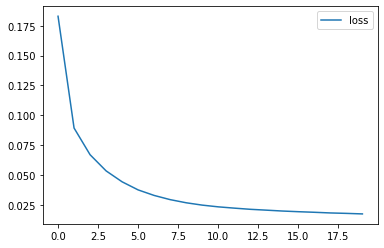

In [195]:
history = []
for epoch in range(num_epoch):
    losses = []
    model.train()

    for i, data in enumerate(train_iter):
        q1, q2 = data
        q1 = torch.tensor(q1, device='cuda:0')
        q2 = torch.tensor(q2, device='cuda:0')
        # calculate loss, step the optimizers, save losses
        # your code here
        res = model(q1, q2)
        loss_ = loss(*res)
        losses.append(loss_.item())
        loss_.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(losses)
    print(f"Epoch {epoch}\n Current loss {np.mean(losses)}\n")
    history.append(np.mean(losses))

plt.plot(history, label="loss")
plt.legend()
plt.show()

In [88]:
model.eval()

SiameseModel(
  (emb): Embedding(76195, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (ll): Linear(in_features=256, out_features=1, bias=True)
)

In [189]:
def classify(test_q1, test_q2, y, threshold, model, vocab, data_generator=data_generator, batch_size=64):
    """Function to test the accuracy of the model.

    Args:
        test_Q1 (numpy.ndarray): Array of Q1 questions.
        test_Q2 (numpy.ndarray): Array of Q2 questions.
        y (numpy.ndarray): Array of actual target.
        threshold (float): Desired threshold.
        model: The Siamese model.
        vocab (collections.defaultdict): The vocabulary used.
        data_generator (function): Data generator function. Defaults to data_generator.
        batch_size (int, optional): Size of the batches. Defaults to 64.

    Returns:
        float: Accuracy of the model.
    """       
    accuracy = 0
    ### START CODE HERE (Replace 'None' with your code) ###
    # Call the data generator (built in Ex 01) with shuffle= None
    for ix, i in enumerate(zip(*data_generator(test_q1, test_q2, batch_size, pad=vocab['<PAD>'], shuffle=None))):
        # Hint: use `vocab['<PAD>']` for the `pad` argument of the data generator
        q1, q2 = i
        # use batch size chuncks of actual output targets (same syntax as example above)
        y_test = y[ix*batch_size:(ix+1)*batch_size]
        # Call the model
        v1, v2 = model(torch.tensor(q1, device='cuda:0'), torch.tensor(q2, device='cuda:0'))
        v1 = v1.detach().cpu().numpy()
        v2 = v2.detach().cpu().numpy()
        
        for j in range(len(y_test)):
            # take dot product to compute cos similarity of each pair of entries, v1[j], v2[j]
            # don't forget to transpose the second argument
            d = np.dot(v1[j], v2[j].T)
            #print(d)
            # is d greater than the threshold?
            res = d > threshold
            # increment accurancy if y_test is equal `res`
            accuracy += (y_test[j] == res)
    # compute accuracy using accuracy and total length of test questions
    accuracy = accuracy / len(test_q1)
    ### END CODE HERE ###
    
    return accuracy

In [196]:
accuracy = classify(q1_test, q2_test, y_test, 0.7, model, vocab, batch_size = 512) 
print("Accuracy", accuracy) # your final accuracy should be higher than 0.7

Accuracy 0.7171026594902644
